# Pair Programming Decision Tree:

Hasta ahora hemos ajustado el modelo usando una Regresión Logística, pero como hemos aprendido, podemos usar el Decision Tree en este tipo de problemas. Los objetivos de este pair programming:

In [41]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd
# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score , cohen_kappa_score, roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

- ### Ajustad un modelo de Decision Tree a nuestros datos.


In [42]:
#abrimos el DF estandarizado:

df = pd.read_csv('datos/EST_Social_Network_Ads_Aj_int.csv', index_col=0)
df.head()

,age,estimatedsalary,purchased,gender_Female,gender_Male
0,19,19000,0,0,1
1,35,20000,0,0,1
2,26,43000,0,1,0
3,27,57000,0,1,0
4,19,76000,0,0,1


In [43]:
#separamos la VD/VR del DF:

X = df.drop('purchased', axis=1)
y = df['purchased']

In [44]:
#generamos los df de entrenamiento y test
x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, random_state = 42)

In [45]:
#creamos el modelo:

arbol = DecisionTreeClassifier(random_state=0)

#fiteamos los datos al modelo:

arbol.fit(x_train, y_train)

#llamamos al max features y hacemos la raíz cuadrada:

max_features = np.sqrt(len(x_train.columns))
print(f'La raíz cuadrada de las columnas del df de entrenamiento es de {max_features}.')

#exploramos la profundidad de nuestro modelo:

print(f'La profundidad de nuestro arbol es de {arbol.tree_.max_depth}.')



La raíz cuadrada de las columnas del df de entrenamiento es de 2.0.
La profundidad de nuestro arbol es de 12.


In [46]:
# calculamos las predicciones de la VR sobre dataframes de test y el entrenamiento:

#para predecir el resultado de la VR en el df de test:
y_pred_test = arbol.predict(x_test)

#para predecir el resultado de la VR en el df de entrenamiento:
y_pred_train = arbol.predict(x_train)


- ### Calculad las métricas de nuestro nuevo modelo.


In [47]:
#invocamos la función para extraer las métricas del test y del train:

def metricas(clases_reales_test, clases_predichas_test, clases_reales_train, clases_predichas_train, modelo):
    # para el df test
    accuracy_test = accuracy_score(clases_reales_test, clases_predichas_test)
    precision_test = precision_score(clases_reales_test, clases_predichas_test)
    recall_test = recall_score(clases_reales_test, clases_predichas_test)
    f1_test = f1_score(clases_reales_test, clases_predichas_test)
    kappa_test = cohen_kappa_score(clases_reales_test, clases_predichas_test)
    
    # para el df train
    accuracy_train = accuracy_score(clases_reales_train, clases_predichas_train)
    precision_train = precision_score(clases_reales_train, clases_predichas_train)
    recall_train = recall_score(clases_reales_train, clases_predichas_train)
    f1_train = f1_score(clases_reales_train, clases_predichas_train)
    kappa_train = cohen_kappa_score(clases_reales_train, clases_predichas_train)
    df = pd.DataFrame({"accuracy": [accuracy_test, accuracy_train],
                       "precision": [precision_test, precision_train],
                       "recall": [recall_test, recall_train],
                       "f1": [f1_test, f1_train],
                       "kapppa": [kappa_test, kappa_train],
                       "set": ["test", "train"]})
    df["modelo"] = modelo
    return df

In [48]:
#aplicamos la función
dt_resultados = metricas(y_test, y_pred_test, y_train, y_pred_train, 'Decision Tree RLog EST')
dt_resultados

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.843750,0.839286,0.746032,0.789916,0.666222,test,Decision Tree RLog EST
1,0.928125,0.904110,0.887892,0.895928,0.841042,train,Decision Tree RLog EST


#### Interpretación:

Comprobamos que existe también un overfitting, donde el cómputo total de train superaría las métricas del test entre un 10 y 15%.

Para reducir nuestro overfitting, tendremos que ajustarnos todavía más al modelo aún teniendo overfitting, ajustando la profundidad:

In [49]:
param = {'max_depth': [2, 4, 6, 7], #bajamos la profundidad
         'max_features': [1, 2, 3], #a partir del resultado del R cuadrado.
         'min_samples_split': [50, 100, 150, 200],
         'min_samples_leaf': [30, 70, 150]}

In [50]:
# una vez creado el diccionario iniciaremos el modelo con GridSearch
gs = GridSearchCV(
            estimator=DecisionTreeClassifier(random_state= 42), # aplicación del modelo de DTree
            param_grid= param, # para que testee nuestros hiperparámetros
            cv=10) # crossvalidation 

In [51]:
#ajuste del modelo con el train:
gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [2, 4, 6, 7], 'max_features': [1, 2, 3],
                         'min_samples_leaf': [30, 70, 150],
                         'min_samples_split': [50, 100, 150, 200]})

In [52]:
#exploramos cuál es el mejor modelo:
best_model = gs.best_estimator_
best_model

DecisionTreeClassifier(max_depth=6, max_features=3, min_samples_leaf=30,
                       min_samples_split=50, random_state=42)

Vemos que, según el GridSearch, el mejor modelo tiene las siguientes características:
- *max_depth* o profundidad máxima de 2.

- *max_features* o raíz cuadrada de 1.

- *min_samples_leaf* o número mínimo de observaciones que debe de tener cada uno de los nodos hijos. En nuestro caso, 80.

- *min_samples_split* o número mínimo de observaciones que puede tener un nodo para dividirse. En nuestro caso, nuestro modelo necesita 100 observaciones como mínimo para poder dividirse.

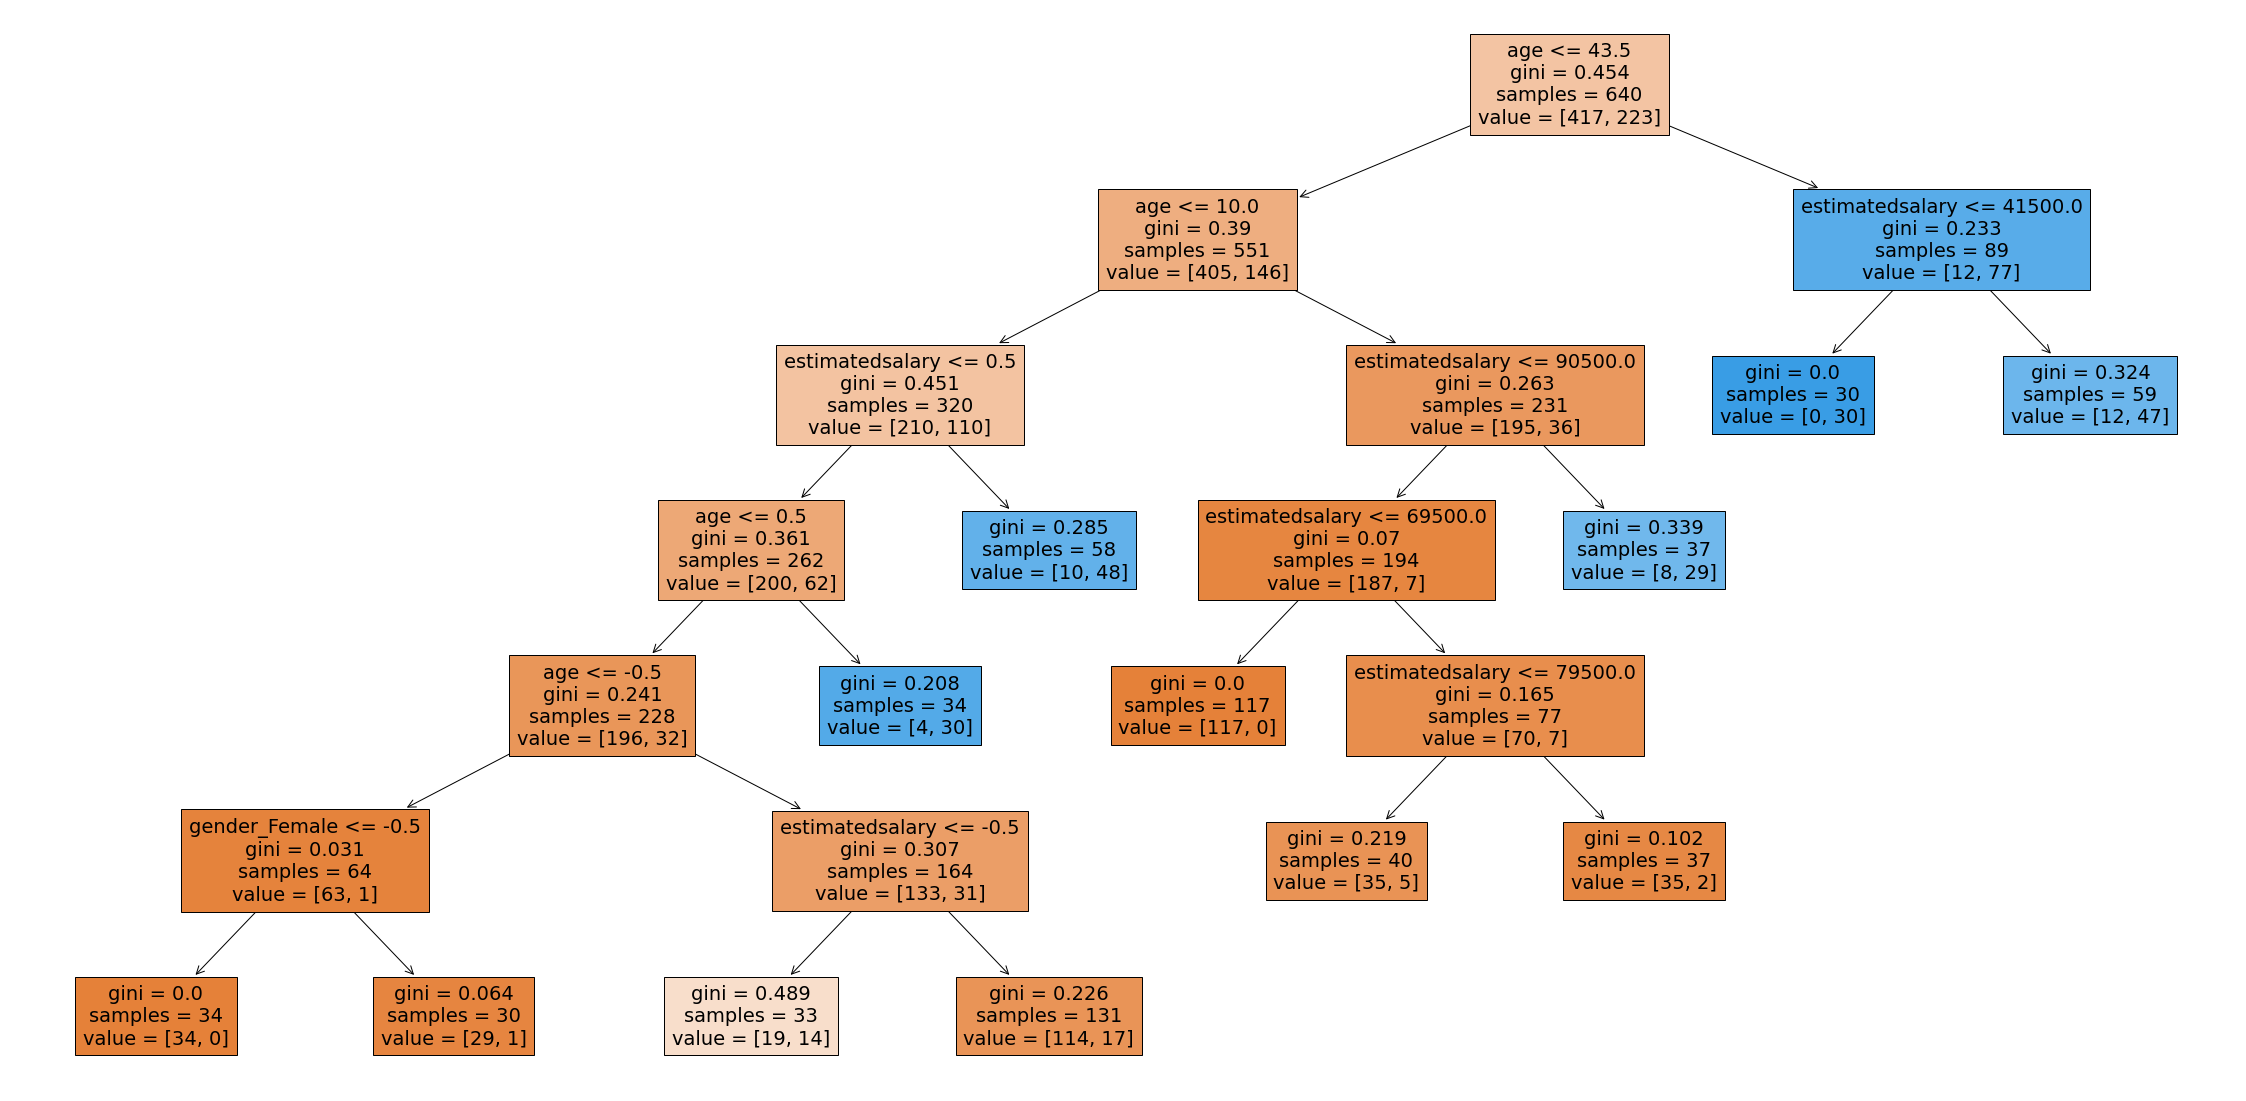

In [53]:
# vamos a representar nuestro árbol gráficamente:
fig = plt.figure(figsize=(40, 20))
tree.plot_tree(best_model, feature_names=x_train.columns, filled=True);

- La 1a división por edad. 417 para un lado y 223 para el otro.
- la 2nda división es con el salario.

RL -- intenta ajustar a los errores al cuadrado más pequeños (la menor suma de cuadrados, SSE)
RLog --  utiliza un chi cuadrado (O - E) ^2 / E en cada división que hace. al mejor ajuste para el chi cuadrado para cada división de datos que hay.


In [54]:
# predecimos para saber cómo de bueno es nuestro modelo:

y_pred_test_BM = best_model.predict(x_test)
y_pred_train_BM = best_model.predict(x_train)

In [55]:
# extraemos los resultados en un df:
dt_results_BM = metricas(y_test, y_pred_test_BM, y_train,  y_pred_train_BM, "Decision Tree EST BM")
dt_results_BM

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.868750,0.875000,0.777778,0.823529,0.719626,test,Decision Tree EST BM
1,0.885938,0.844037,0.825112,0.834467,0.747476,train,Decision Tree EST BM


#### Interpretación:

Podemos apreciar nuevamente un overfitting donde el modelo de entrenamiento supera en el cómputo total de las métricas en aproximadamente un 10% al modelo de test.

El modelo de test tiene un kappa de 0.2 (bajo), por lo que parece que la precisión para 

- ### Comparad las métricas con el modelo hecho hasta ahora. ¿Cuál es mejor?

In [56]:
#abrimos un csv con los resultados de las métricas de modelos anteriores de RL:
results_lr = pd.read_csv('datos/resultados-total-met.csv', index_col=0)

In [57]:
#concatenamos:
results_def = pd.concat([results_lr, dt_results_BM, dt_resultados], axis=0)
results_def

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.600000,0.476190,0.158730,0.238095,0.051325,test,R. log ESTANDARIZADA
1,0.682813,0.631579,0.215247,0.321070,0.174923,train,R. log ESTANDARIZADA
0,0.650000,0.000000,0.000000,0.000000,0.000000,test,R. log SIN estandarizar
1,0.640625,0.000000,0.000000,0.000000,0.000000,train,R. log SIN estandarizar
0,0.868750,0.875000,0.777778,0.823529,0.719626,test,Decision Tree EST BM
1,0.885938,0.844037,0.825112,0.834467,0.747476,train,Decision Tree EST BM
0,0.843750,0.839286,0.746032,0.789916,0.666222,test,Decision Tree RLog EST
1,0.928125,0.904110,0.887892,0.895928,0.841042,train,Decision Tree RLog EST


#### **Interpretación**:


Tras comparar las métricas aplicando los modelos, llegamos a las siguientes conclusiones:

- Partiendo del valor *kappa* de los distintos modelos, los únicos que tiene un nivel de concordania aceptable (> 0.6) son los modelos de Decision Tree (Decision Tree BM (best model) y Decision Tree RLog EST). Es decir, el mejor modelo o estimación del Decision Tree posible (BM) y el Decision Tree antes del ajuste.

- Entre estos dos modelos, observamos que en el DT antes del ajuste se da un overfitting.

- Dado que nos interesa saber qué factores llevan a una persona a pulsar un botón (casos positivos), prestaremos más atención a los parámetros *precision y recall*.

Especialmente, nos interesa el valor del parámetro *precision* dado que queremos saber qué % de casos positivos correctos (Verdaderos Positivos) ha sido capaz de predecir el modelo. 

Si bien es cierto que no vemos una diferencia sustancial entre el valor de precision en el DT sin ajustar (=0.839) y el mejor modelo (=0.875), este último sigue teniendo un valor más cercano al 1, además de tener unas mejores métricas en el resto de las dimensiones.

**Por lo tanto, optaremos por usar el DT con el mejor modelo (BM) al tener las mejores métricas**




In [58]:
#almacenamos en un csv:
results_def.to_csv('datos/ajustes-modelo-DT.csv')